In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 2s 0us/step


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


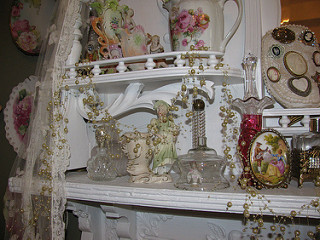

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

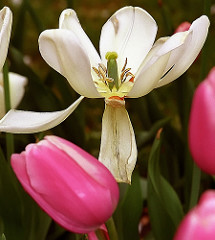

In [5]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
#교차 검증을 위한 데이터 분할
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                               validation_split = 0.2,
                                                               subset = 'training',
                                                               seed = 1995,
                                                               image_size = (img_height, img_width),
                                                               batch_size = batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                               validation_split = 0.2,
                                                               subset = 'validation',
                                                               seed = 1995,
                                                               image_size = (img_height, img_width),
                                                               batch_size = batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


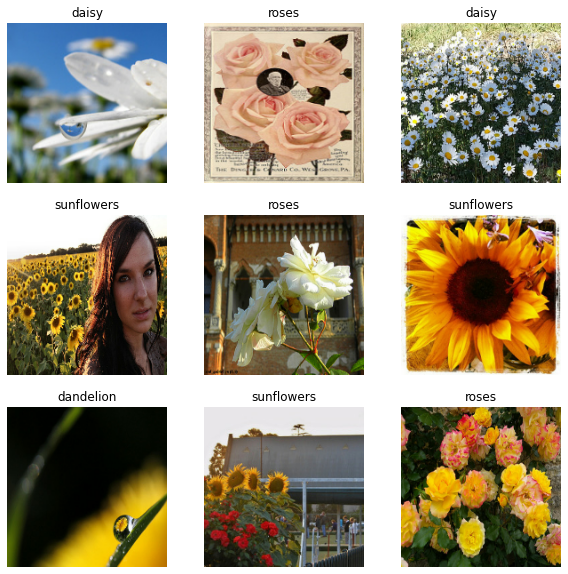

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [13]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# 픽셀값의 범위는 현재 `[0,1]`
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [15]:
num_classes = 5

model = Sequential([
                     layers.experimental.preprocessing.Rescaling(1./255,input_shape = (img_height,
                                                                                       img_width,
                                                                                       3)),
                     layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
                     layers.MaxPooling2D(),
                     layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
                     layers.MaxPooling2D(),
                     layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
                     layers.MaxPooling2D(),
                     layers.Flatten(),
                     layers.Dense(128, activation = 'relu'),
                     layers.Dense(num_classes)
])

In [16]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [18]:
epochs = 10
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs = epochs
)

Epoch 1/10
92/92 [==============================] - 36s 60ms/step - loss: 1.4328 - accuracy: 0.3665 - val_loss: 1.2245 - val_accuracy: 0.4768
Epoch 2/10
92/92 [==============================] - 4s 43ms/step - loss: 1.0281 - accuracy: 0.5906 - val_loss: 1.0160 - val_accuracy: 0.6294
Epoch 3/10
92/92 [==============================] - 4s 42ms/step - loss: 0.8394 - accuracy: 0.6788 - val_loss: 0.9560 - val_accuracy: 0.6349
Epoch 4/10
92/92 [==============================] - 4s 42ms/step - loss: 0.7048 - accuracy: 0.7333 - val_loss: 0.9328 - val_accuracy: 0.6744
Epoch 5/10
92/92 [==============================] - 4s 42ms/step - loss: 0.5256 - accuracy: 0.8110 - val_loss: 0.9139 - val_accuracy: 0.6880
Epoch 6/10
92/92 [==============================] - 4s 42ms/step - loss: 0.3430 - accuracy: 0.8839 - val_loss: 1.0011 - val_accuracy: 0.6812
Epoch 7/10
92/92 [==============================] - 4s 42ms/step - loss: 0.2186 - accuracy: 0.9305 - val_loss: 1.1636 - val_accuracy: 0.6798
Epoch 8/10
9

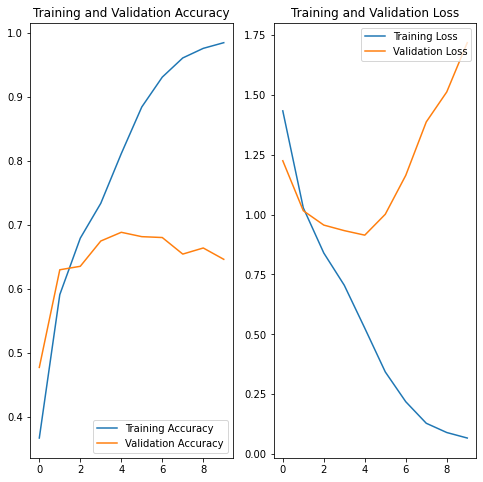

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal",
                                                                                   input_shape = (img_height,
                                                                                                  img_width,
                                                                                                  3)),
                                      layers.experimental.preprocessing.RandomRotation(0.1),
                                      layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

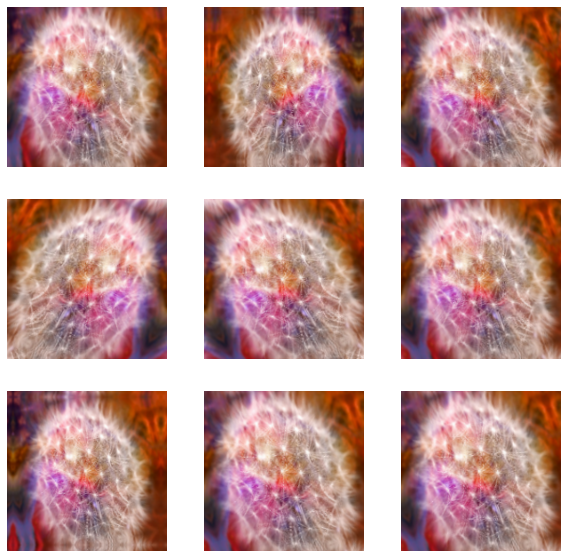

In [21]:
plt.figure(figsize = (10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype('uint8'))
    plt.axis('off')

In [22]:
model = Sequential([data_augmentation, 
                    layers.experimental.preprocessing.Rescaling(1./255,),
                    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
                    layers.MaxPooling2D(),
                    layers.Dropout(0.2),                     
                    layers.Flatten(),
                    layers.Dense(128, activation = 'relu'),
                    layers.Dense(num_classes)
                     ])

In [23]:
model.compile(optimizer= 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True),
              metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [24]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs = epochs
)

Epoch 1/15
92/92 [==============================] - 6s 51ms/step - loss: 1.3824 - accuracy: 0.4053 - val_loss: 1.1581 - val_accuracy: 0.5204
Epoch 2/15
92/92 [==============================] - 4s 49ms/step - loss: 1.0899 - accuracy: 0.5518 - val_loss: 1.0292 - val_accuracy: 0.6213
Epoch 3/15
92/92 [==============================] - 4s 49ms/step - loss: 1.0000 - accuracy: 0.6029 - val_loss: 0.9774 - val_accuracy: 0.6349
Epoch 4/15
92/92 [==============================] - 4s 48ms/step - loss: 0.9150 - accuracy: 0.6396 - val_loss: 0.9241 - val_accuracy: 0.6540
Epoch 5/15
92/92 [==============================] - 4s 48ms/step - loss: 0.8489 - accuracy: 0.6666 - val_loss: 0.9077 - val_accuracy: 0.6717
Epoch 6/15
92/92 [==============================] - 4s 48ms/step - loss: 0.8184 - accuracy: 0.6819 - val_loss: 0.8562 - val_accuracy: 0.6812
Epoch 7/15
92/92 [==============================] - 4s 48ms/step - loss: 0.7655 - accuracy: 0.6969 - val_loss: 0.9334 - val_accuracy: 0.6676
Epoch 8/15
92

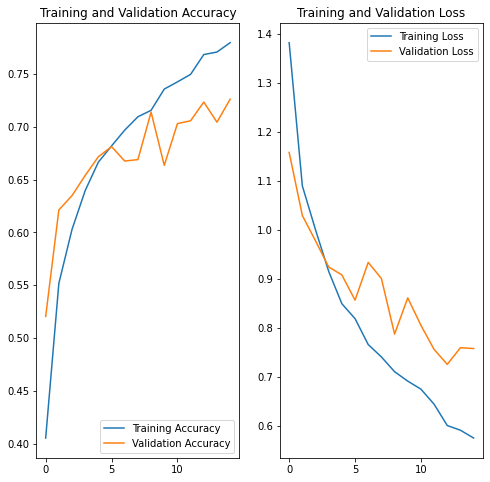

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to tulips with a 61.45 percent confidence.
